In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

import string

%matplotlib inline

In [7]:
def get_hour(item):
    return item.hour

def get_day_frame(directory, date, remove_zeros=True, cutoff_area=10000, dropna_thres=4,
                 parse_filename=False, find_cumtime=True,
                 col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second']):
    """
    Returns the day frame for all files in the directory
    date: (month, date, year) tuple, for adding the relevant columns
    parse_filename: set True for files without timestamp, will infer timestamps from filename
    find_cumtime: set False for files that have intervals that are cumulative instead of dt
    """
    files = glob.glob(directory + '/*.csv') 
    
    if files == []:
        return None
    
    frames = []
    for filename in files:
        obs = pd.read_csv(filename, header=None, names=col_names)
        
        # Remove nan columns
        obs.dropna(thresh=dropna_thres)
        
        # Parse filename to get time of the record
        if parse_filename:
            components = string.split(filename, '_')
            timestr = string.join(components[1:], ':')[:-4]
            endtime = pd.to_datetime(timestr)
            
            
            if find_cumtime:
                cum_time = np.cumsum(obs.Interval)
            else:
                cum_time = obs.Interval
            
            cum_time_delta = pd.to_timedelta(cum_time, unit='s')
            starttime = endtime - cum_time_delta[obs.shape[0] - 1]
            obs['Time'] = starttime + cum_time_delta
        
                 
        frames.append(obs)

    # Concatenate readings from all files
    day_frame = pd.concat(frames)
    day_frame['Day'] = date[1]
    day_frame['Month'] = date[0]
    day_frame['Year'] = date[2]
    
    if not parse_filename:
        day_frame['Time'] = pd.to_datetime(day_frame[['Day','Month', 'Year','Hour','Minute','Second']])
    
    # Light hour is from 9am to 7pm
    day_frame['Light'] = (day_frame.Time.apply(get_hour) >= 7) & (day_frame.Time.apply(get_hour) <= 21)
    
    # Remove zeros if specified
    if remove_zeros:
        day_frame = day_frame[(day_frame['x'] != 0) & (day_frame['y'] != 0)]
        
    # Remove entries which exceed a cutoff area
    if cutoff_area != None:
        day_frame = day_frame[day_frame.Area < cutoff_area]
        
    
    
    return day_frame
  

def collect_all_days(parent_dir, days, remove_zeros=True, cutoff_area=10000, dropna_thres=4,
                  parse_filename=False, find_cumtime=True,
                  col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second']):
    '''
    ------------------------
    Inputs:
    parent_dir: string indicating parent directory
    days: list of recording days
    ------------------------
    Output:
    A pd frame for all observations of that animal
    ------------------------    
    '''
    frames = []
    for day in days:
        #datestr = str(day[0]) + '/' + str(day[1]) + '/' + str(day[2])
        #datetime = pd.to_datetime(datestr)
        directory = parent_dir + day.strftime('%m%d') #+ '_proc/'
        print directory
        if os.path.isdir(directory):
            day_frame = get_day_frame(directory, (day.month, day.day, day.year),
                                     remove_zeros, cutoff_area, dropna_thres,
                                     parse_filename, find_cumtime, col_names)
            frames.append(day_frame)
        else:
            print '     Directory does not exist'
    
    return pd.concat(frames)

In [20]:
np.diff?

In [59]:
def get_displacement(day_frame):
    '''
    Get displacement from x and y coords
    '''
    
    dx = np.diff(day_frame['x'])
    dy = np.diff(day_frame['y'])
    displacement = np.sqrt(dx * dx + dy * dy)
    
    # Diff returns n-1 values, so concatenate a 0 behind and make a new column
    return np.concatenate((displacement, [0])) 

def get_zeit(day_frame, start_time_str=None, use_time_field=False):
    '''
    Compute the zeitgeber time, starting from 9am, in unit of hours
    '''
    timeseries = day_frame.Time
    
    if start_time_str == None:
        starttime = timeseries[0]
    else:
        starttime = pd.to_datetime(start_time_str)

    return (timeseries - starttime) / pd.Timedelta(1, unit='h')

def get_crossing(day_frame, xline=160):
    '''
    Compute the time of crossings across the specified xline
    Will return an np array with T being the time of crossing
    '''
    leftright = day_frame.x < 160
    diff = np.diff(leftright)
    
    return np.concatenate((diff, [0])) 

def plot_all_data(frame, axis):
    '''
    Make a plot of all displacement values
    '''
    axis.plot(frame['ZeitTime'], frame['Displacement'], '.', alpha=0.3)
    axis.fill_between(frame.ZeitTime, 0, axis.get_ylim()[1], 
                    where=~frame.Light, color='gray',  alpha=0.3)
    axis.set_xlabel('Zeitbeger time (h)')
    axis.set_ylabel('Displacement (pix)')
    
def ecdf(data):
    return np.sort(data), np.arange(len(data)) / float(len(data))

def aggregate_activity(day_frame, time, unit, axis=None, plot=False,
                      name='Bird', save=False):
    """
    Unit: either 'Hour', 'Minute', or 'Second'
    If plot set to True, also plot the activity
    Returns a data frame which is the total distance travelled in time * unit time specified
    """
    if unit == 'Hour':
        scale = 3600
    elif unit == 'Minute':
        scale = 60
    elif unit == 'Second':
        scale = 1
    else:
        raise ValueError('Invalid time unit')
        
    group_duration = time * scale # Number of seconds to group
    SECS_PER_DAY = 3600 * 24
    
    # ZeitTime is measured in hours, partitioned into groups of
    # specified group_duration
    group = (day_frame['ZeitTime'] / (group_duration/3600.0)).astype('int')
    agg_displacement = day_frame[['Displacement', 'Crosses']].groupby(group)
    
    agg_sum_grouped = agg_displacement.sum().reset_index()
    
    # Create data frame with day information
    agg_sum_grouped['Day'] = (agg_sum_grouped['ZeitTime'] / (SECS_PER_DAY / group_duration)).astype('int')
    agg_sum_grouped['Period'] = agg_sum_grouped['ZeitTime'] % int(SECS_PER_DAY / group_duration)
    
    # Produce a plot if instructed
    if plot:
        for day in agg_sum_grouped.Day.unique():
            activity_day = agg_sum_grouped.Displacement[agg_sum_grouped.Day == day]
            crosses_day = agg_sum_grouped.Crosses[agg_sum_grouped.Day == day]
            time_in_day = agg_sum_grouped.Period[agg_sum_grouped.Day == day] /3
            axis[0].plot(time_in_day, activity_day)
            axis[1].plot(time_in_day, crosses_day)
        axis[0].set_xlabel('Time (hour)')
        axis[0].set_ylabel('Total distance in 20 minutes')
        axis[1].set_xlabel('Time (hour)')
        axis[1].set_ylabel('Crosses in 20 minutes')
    
    return agg_sum_grouped

In [63]:
def process_animal(name, start_day_str, start_time_str=' 7:00AM', ndays=5,  
                   time=20, unit='Minute', save=False, 
                   cutoff_area=None, parse_filename=False, find_cumtime=True,
                  col_names = ['Interval', 'x', 'y', 'Area', 'Hour', 'Minute', 'Second'],
                  xline=160):
    '''
    Perform the analysis procedure for the specified animal
    name: string for name of animal, will read from folder of the same name
    start_day_str: string that represents start day, e.g. '9/25/2016'
    periods: number of days to read
    save: indicates whether the final frame should be saved to a .csv
    '''
    days = pd.date_range(start_day_str, periods=ndays, freq='d')
    frame_all = collect_all_days(name + '/', days, 
                                cutoff_area=cutoff_area, parse_filename=parse_filename,
                                find_cumtime=find_cumtime, col_names=col_names)

    # Sort, then calculate displacement and zeitbeger time
    frame_all = frame_all.sort_values('Time')
    frame_all['Displacement'] = get_displacement(frame_all)
    frame_all['ZeitTime'] = get_zeit(frame_all, start_time_str=start_day_str + start_time_str)
    frame_all['Crosses'] = get_crossing(frame_all, xline=xline)
 
    # Make plots of (1) all displacement points (2) binned activity, 20 minutes
    fig, ax = plt.subplots(1, 3, figsize=(18,10))
    plot_all_data(frame_all, ax[0])

    activity = aggregate_activity(frame_all, time=time, unit=unit, 
                                  plot=True, axis=(ax[1], ax[2]), save=save, name=name)
    
    # Save the frame when instructed
    if save:
        activity['Animal'] = name
        activity['Bin duration - ' + unit ] = time
        activity['Start Time'] = pd.to_datetime(start_day_str + start_time_str)
        save_filename = 'Binned_results/' + name + '_binned_20min_073117.csv'
        if not os.path.isfile(save_filename):
            activity.to_csv(save_filename)
        else:
            raise IOError('File exists, cannot overwrite...')
            
    return (frame_all, activity)

## Functions for trajectory and heat-map plotting

In [5]:
def plot_trajectory(frame, start_time_str, end_time_str, return_fr=False):
    '''
    Given a frame, plot the animal's trajectory during the specified period
    Returns the frame used for plotting
    '''
    start_time = pd.to_datetime(start_time_str)
    end_time = pd.to_datetime(end_time_str)
    frame_interest = frame[(frame.Time > start_time) & (frame.Time < end_time)]
    plt.plot(frame_interest.x, frame_interest.y)
    
    if return_fr:
        return frame_interest
    
def plot_heatmap(frame, start_time_str, end_time_str, return_fr=False):
    '''
    Given a frame, plot the animal's trajectory during the specified period
    Returns the frame used for plotting
    '''
    start_time = pd.to_datetime(start_time_str)
    end_time = pd.to_datetime(end_time_str)
    frame_interest = frame[(frame.Time > start_time) & (frame.Time < end_time)]
    
    heatmap, x_edges, y_edges  = np.histogram2d(frame_interest.x, frame_interest.y, 
                                  weights=frame_interest.Interval, bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    with sns.axes_style("dark"):
        plt.imshow(heatmap.T, extent=extent, cmap='jet')
        
    if return_fr:
        return heatmap
    

(array([  5.90640100e+06,   1.00000000e+00,   0.00000000e+00,
          4.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          9.94212000e+05]),
 array([   200.,   5940.,  11680.,  17420.,  23160.,  28900.,  34640.,
         40380.,  46120.,  51860.,  57600.]),
 <a list of 10 Patch objects>)

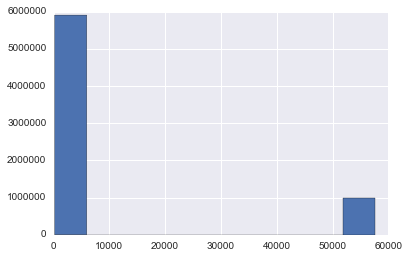

In [12]:
plt.hist(fr_2CW100.y)

In [57]:
activity

,ZeitTime,Displacement,Crosses,Day,Period
0,6,79243.082467,164,0,6
1,7,81572.571842,234,0,7
2,8,31232.365077,56,0,8
3,9,87446.370135,158,0,9
4,10,112361.057323,322,0,10
5,11,100836.084715,271,0,11
6,12,136137.105924,340,0,12
7,13,114308.432688,305,0,13
8,14,62469.096626,166,0,14
9,15,97663.686941,263,0,15


2CW100/0925
2CW100/0926
2CW100/0927
2CW100/0928
2CW100/0929


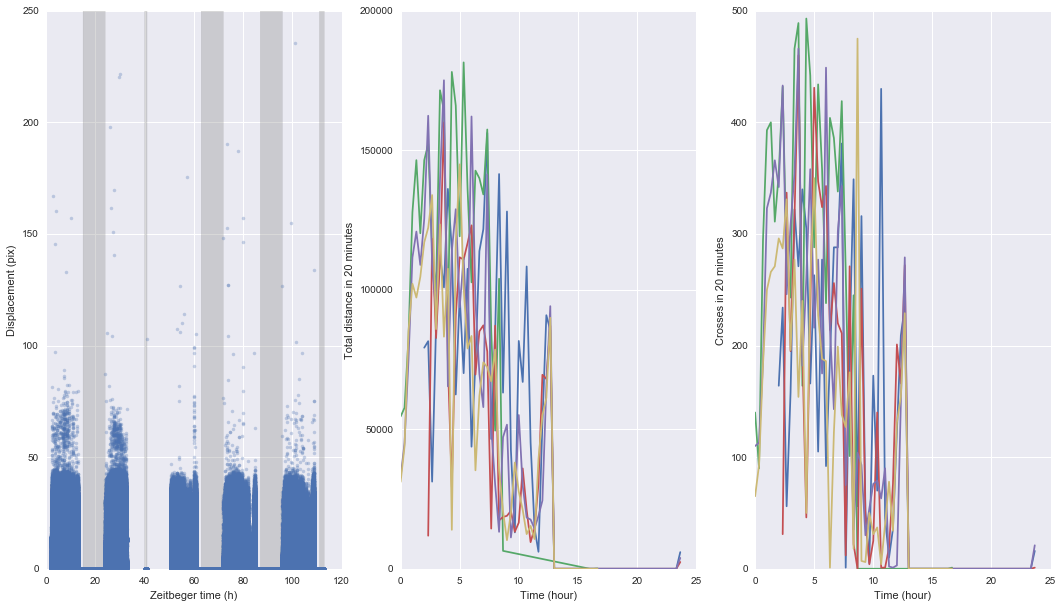

In [64]:
fr, activity = process_animal('2CW100', '9/25/2016', ndays=5, save=True)

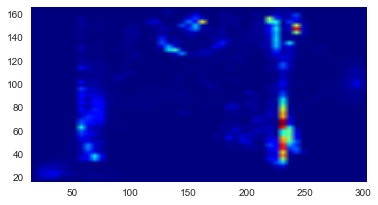

In [102]:
hm = plot_heatmap(fr_2CW100, '9/29/2016 10:00AM', '9/29/2016 4:00PM', return_fr=False)

2CW305/0714
2CW305/0715
2CW305/0716
2CW305/0717


(       Interval        x       y  Area  Hour  Minute  Second  \
 0      0.398700   55.220  43.034   879    15      34  16.199   
 1      0.043062   58.694  42.909   770    15      34  16.242   
 2      0.061657   53.691  42.310   841    15      34  16.304   
 3      0.026670   53.649  42.528   832    15      34  16.331   
 4      0.057288   53.418  42.383   823    15      34  16.388   
 5      0.016808   53.710  42.424   849    15      34  16.406   
 6      0.016363   53.613  42.378   837    15      34  16.422   
 7      0.036031   52.786  42.167   837    15      34  16.458   
 8      0.036078   57.934  43.097   725    15      34  16.494   
 9      0.025636   53.928  42.455   844    15      34  16.520   
 10     0.035845   53.781  42.606   830    15      34  16.556   
 11     0.048711   53.948  42.346   842    15      34  16.604   
 12     0.025302   53.457  42.382   823    15      34  16.630   
 13     0.049491   51.357  42.927   765    15      34  16.679   
 14     0.025970   53.514

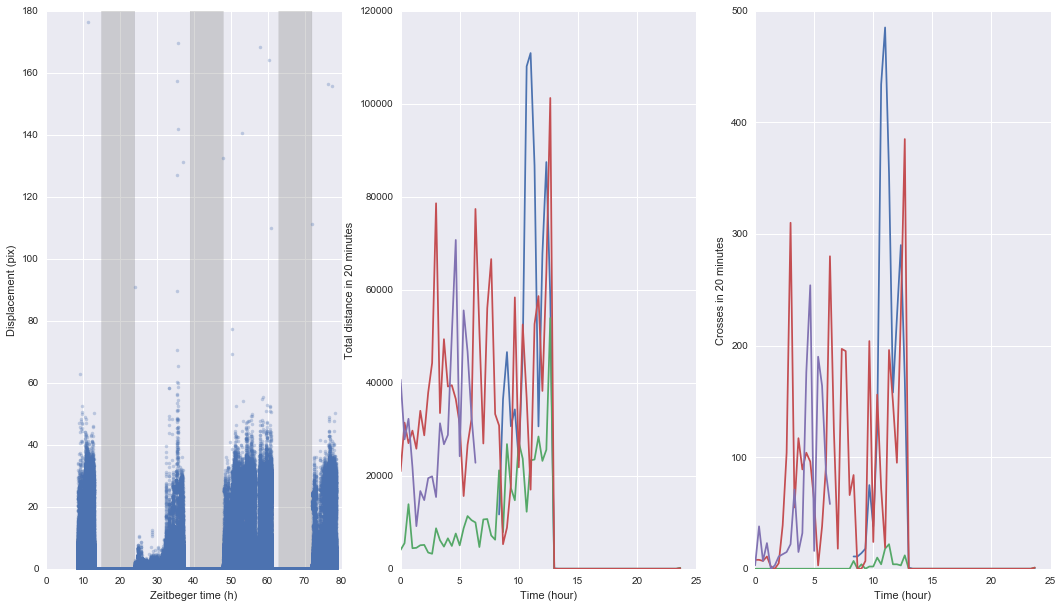

In [65]:
process_animal('2CW305', '7/14/2016', ndays=4, parse_filename=True, save=True)

2CW318/0628
2CW318/0629
2CW318/0630
2CW318/0701


(     Interval        x       y  Area  Hour  Minute  Second  \
 0     0.34287   80.821  61.762   NaN   NaN     NaN     NaN   
 1     0.87399   81.572  66.187   NaN   NaN     NaN     NaN   
 2     1.33610  122.710  56.498   NaN   NaN     NaN     NaN   
 3     1.50970  122.370  56.534   NaN   NaN     NaN     NaN   
 4     1.65590  122.700  56.644   NaN   NaN     NaN     NaN   
 5     1.77810  122.630  56.595   NaN   NaN     NaN     NaN   
 6     1.89510  122.770  56.583   NaN   NaN     NaN     NaN   
 7     2.00380  122.710  56.539   NaN   NaN     NaN     NaN   
 8     2.11280  122.770  56.563   NaN   NaN     NaN     NaN   
 9     2.23160  122.780  56.537   NaN   NaN     NaN     NaN   
 10    2.33600  122.760  56.532   NaN   NaN     NaN     NaN   
 11    2.49610  122.690  56.600   NaN   NaN     NaN     NaN   
 12    2.61950  122.440  56.348   NaN   NaN     NaN     NaN   
 13    2.73980  122.010  56.395   NaN   NaN     NaN     NaN   
 14    2.85940  122.380  56.556   NaN   NaN     NaN    

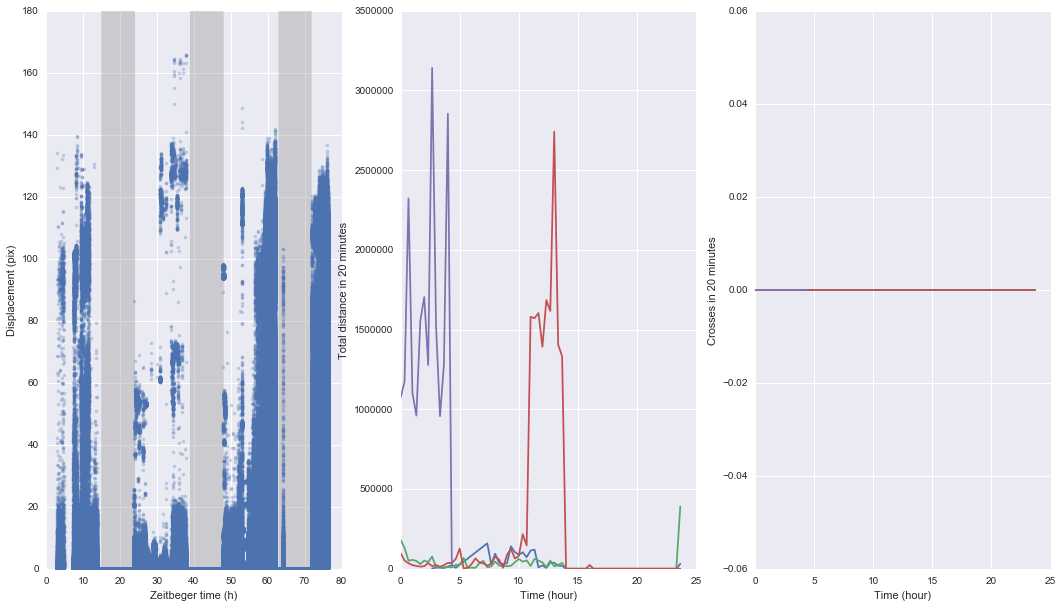

In [67]:
process_animal('2CW318', '6/28/2016', ndays=4, save=True, parse_filename=True, find_cumtime=False)

LB21/0701
LB21/0702
LB21/0703
LB21/0704
LB21/0705


(       Interval         x        y  Area  Hour  Minute  Second  \
 0      0.310580  114.3200  32.3160   NaN   NaN     NaN     NaN   
 1      0.029166  113.8500  32.1480   NaN   NaN     NaN     NaN   
 2      0.518720   16.9160  35.8990   NaN   NaN     NaN     NaN   
 3      0.026843   16.3110  36.2490   NaN   NaN     NaN     NaN   
 4      0.028421   17.2000  36.4290   NaN   NaN     NaN     NaN   
 5      0.022162   18.5710  37.6700   NaN   NaN     NaN     NaN   
 6      0.024989   16.6990  40.0720   NaN   NaN     NaN     NaN   
 7      0.042392   17.1790  42.3280   NaN   NaN     NaN     NaN   
 8      0.024636   17.5100  46.0640   NaN   NaN     NaN     NaN   
 9      0.047878   17.8630  47.7260   NaN   NaN     NaN     NaN   
 10     0.040512   19.0090  48.4550   NaN   NaN     NaN     NaN   
 11     0.023648   18.8210  48.6300   NaN   NaN     NaN     NaN   
 12     0.043284   18.4150  48.4640   NaN   NaN     NaN     NaN   
 13     0.023730   18.4680  48.3950   NaN   NaN     NaN     Na

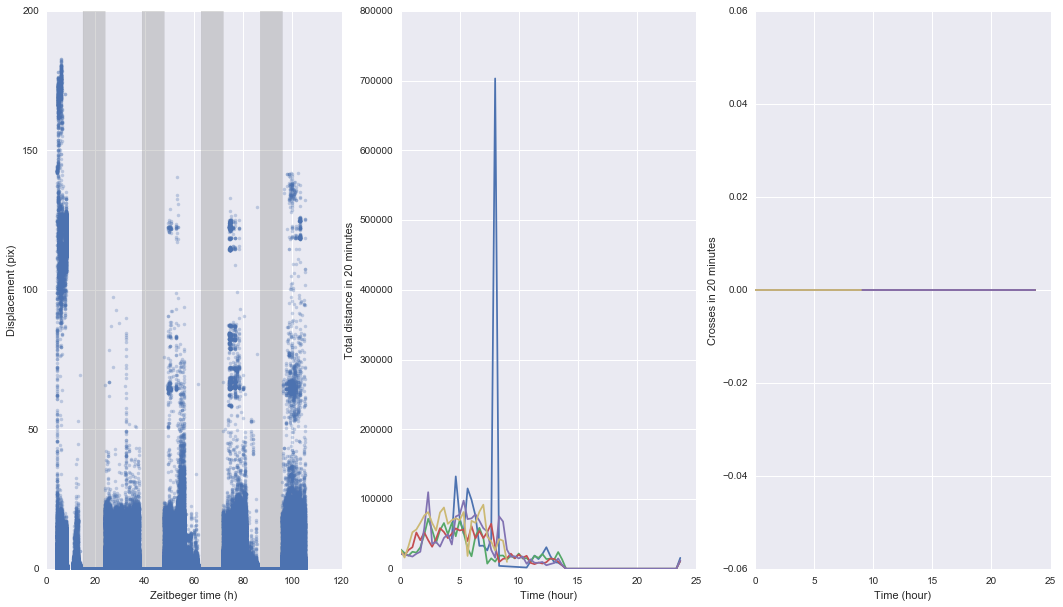

In [68]:
process_animal('LB21', '7/1/2016', ndays=5, save=True, parse_filename=True)

2CW312/0709
2CW312/0710
2CW312/0711
2CW312/0712
2CW312/0713
2CW312/0714


(       Interval        x       y  Area  Hour  Minute  Second  \
 3566   0.032007   61.142  37.302   212     0       0  40.232   
 3567   0.032215   61.067  37.774   208     0       0  40.264   
 3568   0.026465   61.256  37.870   223     0       0  40.291   
 3569   0.036646   61.568  38.183   241     0       0  40.328   
 3570   0.027168   61.434  38.209   235     0       0  40.355   
 3571   0.037677   69.509  41.585   369     0       0  40.393   
 3572   0.047506   61.323  39.726   266     0       0  40.440   
 3573   0.027664   69.309  44.445   524     0       0  40.468   
 3574   0.037815   70.168  45.495   553     0       0  40.506   
 3575   0.027658   66.074  42.953   430     0       0  40.533   
 3576   0.038000   69.798  45.867   579     0       0  40.571   
 3577   0.028201   69.957  46.178   556     0       0  40.599   
 3578   0.028182   66.186  43.546   452     0       0  40.628   
 3579   0.038737   69.798  46.027   594     0       0  40.666   
 3580   0.028547   69.791

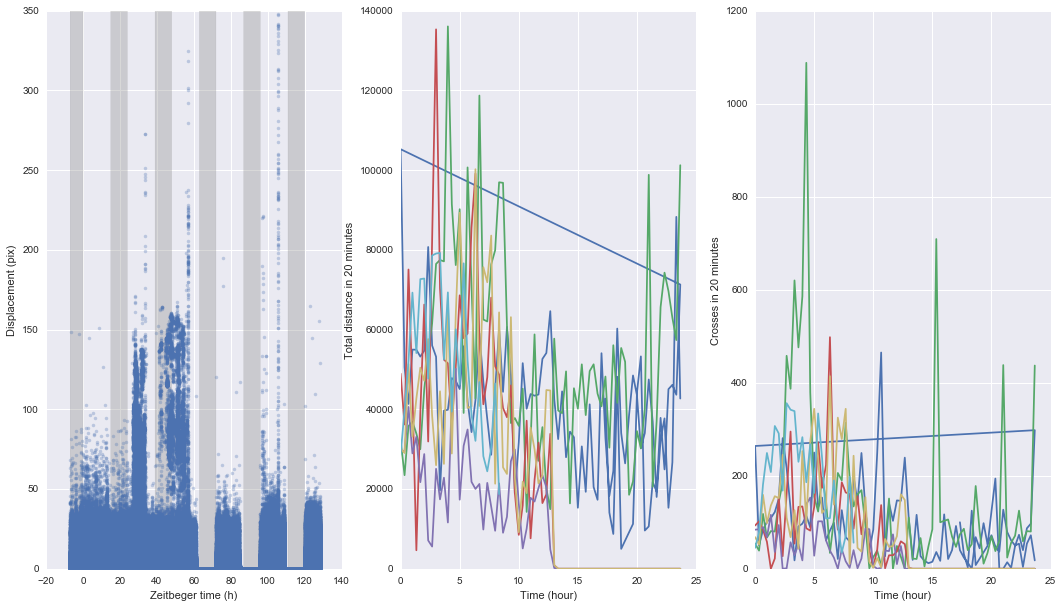

In [69]:
process_animal('2CW312', '7/9/2016', ndays=6, save=True, parse_filename=True)

LB15/0711
LB15/0712
LB15/0713
LB15/0714


(       Interval       x       y   Area  Hour  Minute  Second  Day  Month  \
 27768  0.048282  197.55  118.41    617     0       0   0.017   11      7   
 27769  0.026933  197.50  118.31    608     0       0   0.044   11      7   
 27770  0.026422  197.66  118.32    607     0       0   0.070   11      7   
 27771  0.026203  197.26  118.49    622     0       0   0.097   11      7   
 27772  0.036895  197.57  118.24    607     0       0   0.133   11      7   
 27773  0.047692  197.64  118.20    614     0       0   0.181   11      7   
 27774  0.026953  197.54  117.93    612     0       0   0.208   11      7   
 27775  0.047401  197.49  116.80    610     0       0   0.255   11      7   
 27776  0.026491  197.81  116.18    592     0       0   0.282   11      7   
 27777  0.026972  197.84  116.22    585     0       0   0.309   11      7   
 27778  0.026876  197.83  116.27    599     0       0   0.336   11      7   
 27779  0.038594  197.83  116.18    594     0       0   0.374   11      7   

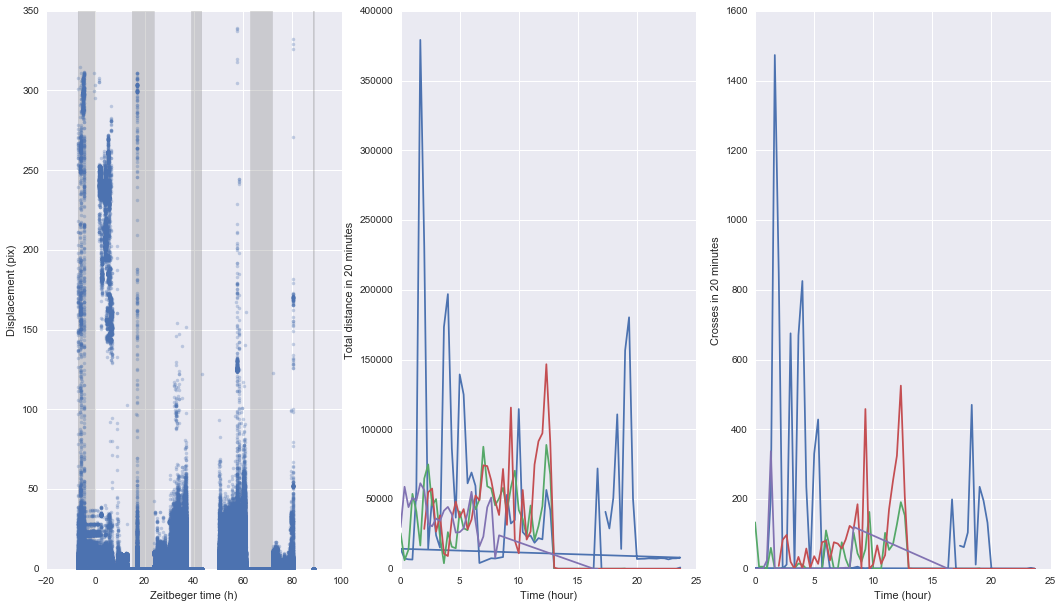

In [70]:
process_animal('LB15', '7/11/2016', ndays=4, save=True)

2CW306/0719
2CW306/0720
2CW306/0721
2CW306/0722


(       Interval        x       y   Area  Hour  Minute  Second  Day  Month  \
 2      0.078429   58.678  19.270    115    17      53  54.329   19      7   
 3      0.027516   58.991  19.239    117    17      53  54.356   19      7   
 5      0.025104   59.025  19.308    120    17      53  54.436   19      7   
 6      0.016389   57.695  19.086    105    17      53  54.452   19      7   
 15     0.033467   58.909  19.136    110    17      53  54.765   19      7   
 16     0.024831   58.380  19.710    100    17      53  54.790   19      7   
 22     0.025295   59.252  19.318    107    17      53  54.983   19      7   
 23     0.048645   58.275  19.667    102    17      53  55.031   19      7   
 29     0.027992   58.020  19.277    101    17      53  55.229   19      7   
 34     0.039115   58.029  19.412    102    17      53  55.396   19      7   
 40     0.047811   58.806  19.343    108    17      53  55.601   19      7   
 94     0.024068   60.559  20.027    111    17      53  57.379  

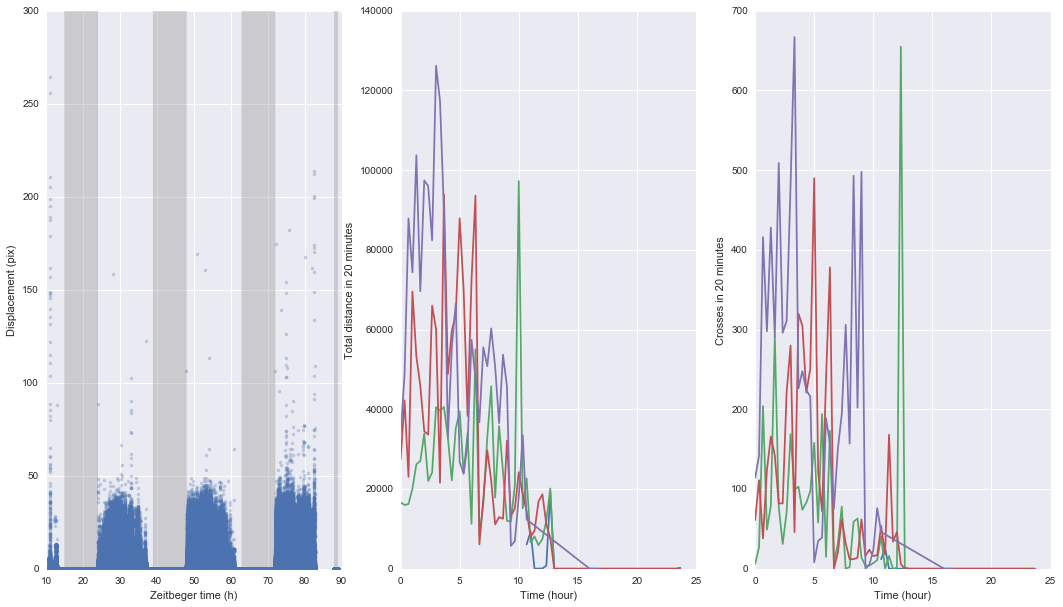

In [71]:
process_animal('2CW306', '7/19/2016', ndays=4, save=True)

2CW308/0714
2CW308/0715
2CW308/0716
2CW308/0717


(       Interval        x       y   Area  Hour  Minute  Second  Day  Month  \
 0      0.524720   77.425  47.168    888    15      33  45.800   14      7   
 1      0.046491   77.659  47.467    881    15      33  45.847   14      7   
 2      0.067136   77.943  47.703    878    15      33  45.914   14      7   
 3      0.031771   77.767  47.572    876    15      33  45.946   14      7   
 4      0.060023   77.870  47.695    875    15      33  46.007   14      7   
 5      0.019032   77.621  47.451    889    15      33  46.026   14      7   
 6      0.017838   77.936  47.741    869    15      33  46.044   14      7   
 7      0.027963   77.725  47.464    873    15      33  46.072   14      7   
 8      0.037655   77.794  47.569    879    15      33  46.110   14      7   
 9      0.027523   77.591  47.349    886    15      33  46.137   14      7   
 10     0.037974   77.572  47.315    894    15      33  46.175   14      7   
 11     0.027913   77.712  47.575    879    15      33  46.203  

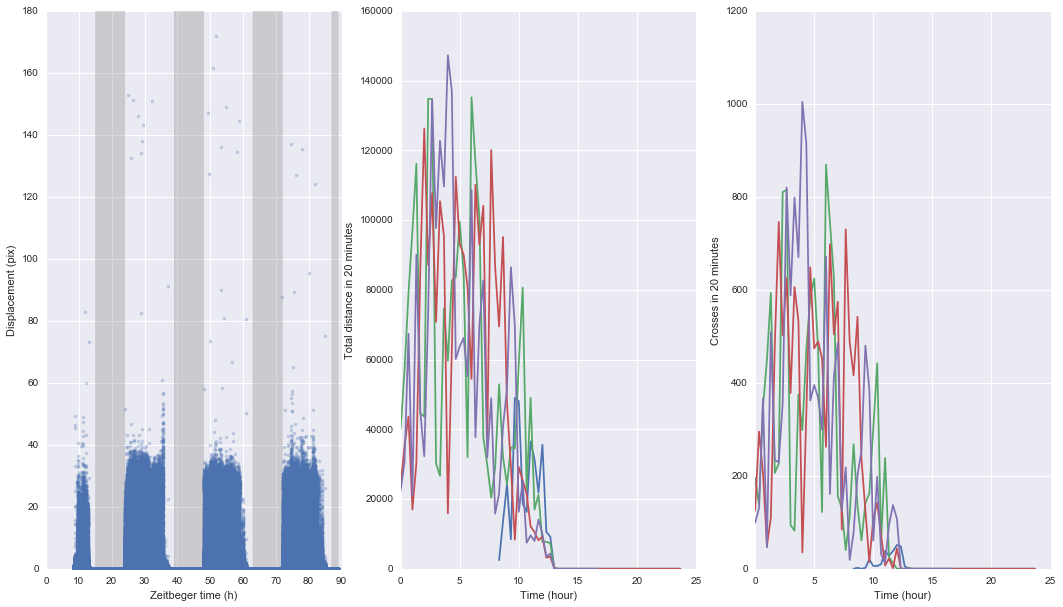

In [72]:
process_animal('2CW308', '7/14/2016', ndays=4, save=True)

LB06/0718
LB06/0719
LB06/0720


(       Interval      x     y   Area  Hour  Minute  Second  Day  Month  Year  \
 14741   0.14236  160.5  90.5  57600     0       0   0.078   18      7  2016   
 14742   0.12768  160.5  90.5  57600     0       0   0.205   18      7  2016   
 14743   0.11630  160.5  90.5  57600     0       0   0.322   18      7  2016   
 14744   0.15838  160.5  90.5  57600     0       0   0.480   18      7  2016   
 14745   0.12696  160.5  90.5  57600     0       0   0.607   18      7  2016   
 14746   0.12573  160.5  90.5  57600     0       0   0.733   18      7  2016   
 14747   0.13996  160.5  90.5  57600     0       0   0.873   18      7  2016   
 14748   0.13480  160.5  90.5  57600     0       0   1.008   18      7  2016   
 14749   0.11704  160.5  90.5  57600     0       0   1.125   18      7  2016   
 14750   0.15108  160.5  90.5  57600     0       0   1.276   18      7  2016   
 14751   0.11538  160.5  90.5  57600     0       0   1.392   18      7  2016   
 14752   0.12607  160.5  90.5  57600    

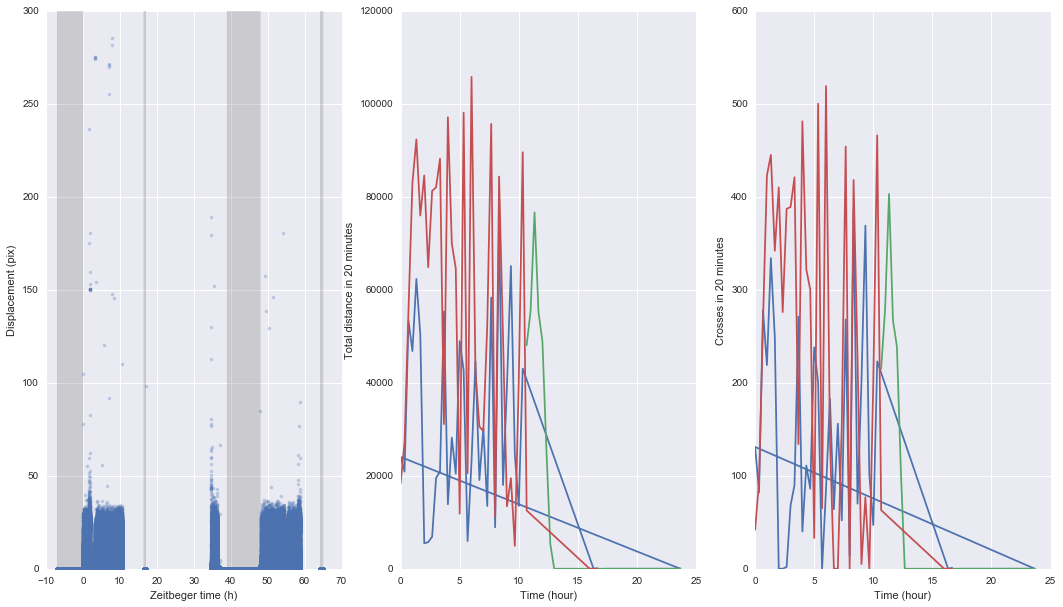

In [73]:
process_animal('LB06', '7/18/2016', ndays=3, save=True)

Or130/0722
Or130/0723
Or130/0724
Or130/0725
Or130/0726
Or130/0727
Or130/0728


(       Interval       x       y   Area  Hour  Minute  Second  Day  Month  \
 0      0.711340  231.47  113.45    811    17      44  34.608   22      7   
 1      0.044398  231.45  113.44    801    17      44  34.652   22      7   
 2      0.132700  231.30  113.51    810    17      44  34.785   22      7   
 3      0.024368  231.26  113.53    813    17      44  34.810   22      7   
 4      0.085044  231.51  113.48    803    17      44  34.895   22      7   
 5      0.017074  231.78  113.44    797    17      44  34.913   22      7   
 6      0.026442  231.80  113.50    798    17      44  34.940   22      7   
 7      0.025928  231.71  113.42    800    17      44  34.965   22      7   
 8      0.035233  231.80  113.46    796    17      44  35.001   22      7   
 9      0.026372  231.56  113.55    807    17      44  35.027   22      7   
 10     0.035602  231.68  113.52    801    17      44  35.063   22      7   
 11     0.064130  231.69  113.45    793    17      44  35.127   22      7   

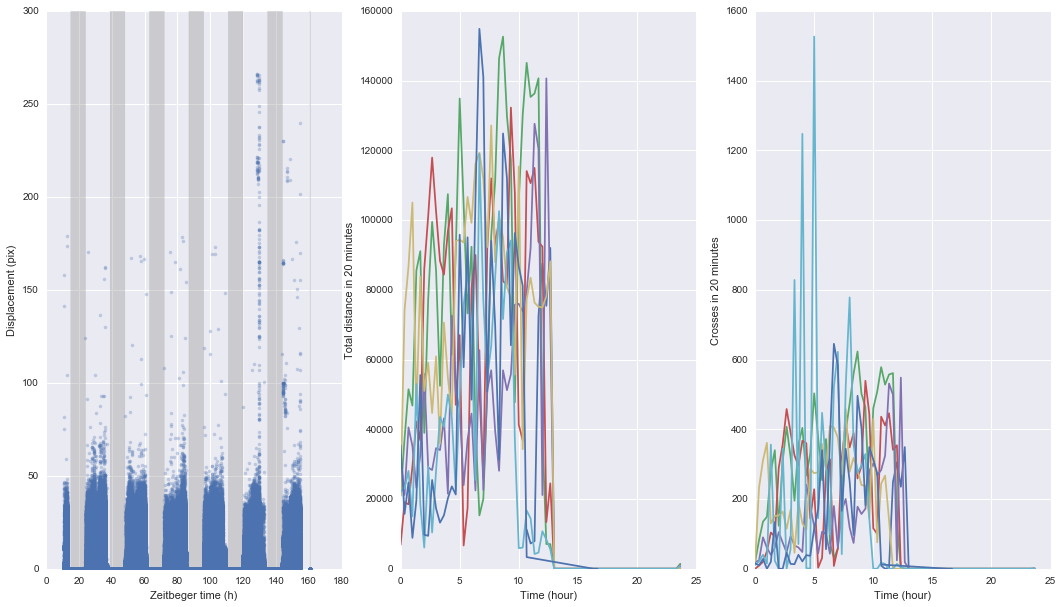

In [74]:
process_animal('Or130', '7/22/2016', ndays=7, save=True)

Or114/0726
Or114/0727
Or114/0728
Or114/0729
Or114/0730
Or114/0731
     Directory does not exist
Or114/0801
Or114/0802
Or114/0803


(       Interval      x     y   Area  Hour  Minute  Second  Day  Month  Year  \
 17438   0.12467  160.5  90.5  57600     0       0   0.003   26      7  2016   
 17439   0.13351  160.5  90.5  57600     0       0   0.137   26      7  2016   
 17440   0.14209  160.5  90.5  57600     0       0   0.279   26      7  2016   
 17441   0.12982  160.5  90.5  57600     0       0   0.409   26      7  2016   
 17442   0.11206  160.5  90.5  57600     0       0   0.521   26      7  2016   
 17443   0.15132  160.5  90.5  57600     0       0   0.672   26      7  2016   
 17444   0.13333  160.5  90.5  57600     0       0   0.807   26      7  2016   
 17445   0.11360  160.5  90.5  57600     0       0   0.920   26      7  2016   
 17446   0.15946  160.5  90.5  57600     0       0   1.080   26      7  2016   
 17447   0.11245  160.5  90.5  57600     0       0   1.192   26      7  2016   
 17448   0.13220  160.5  90.5  57600     0       0   1.324   26      7  2016   
 17449   0.14279  160.5  90.5  57600    

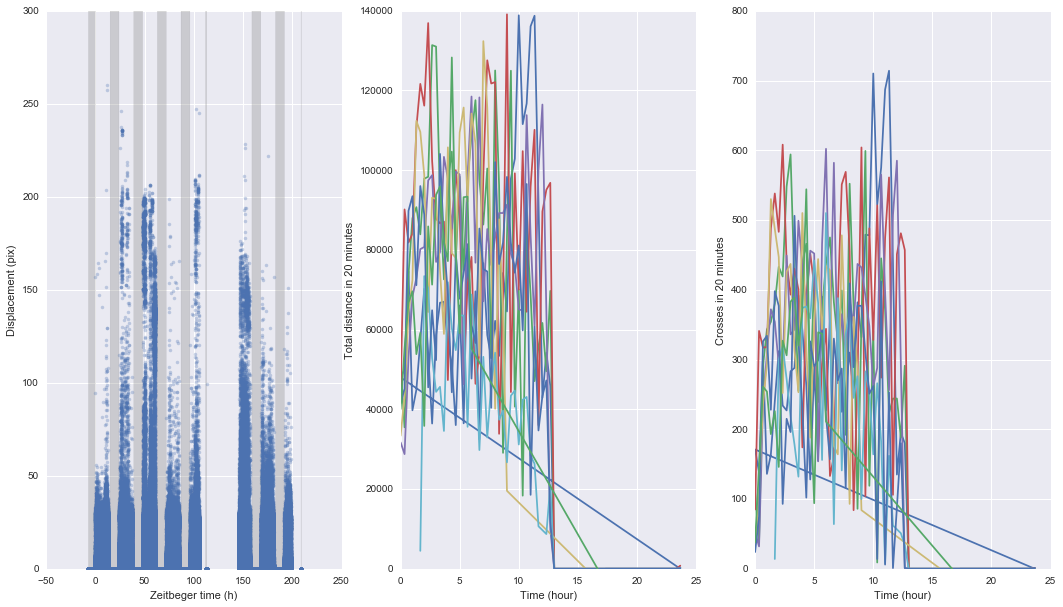

In [75]:
process_animal('Or114', '7/26/2016', ndays=9, save=True)

2CW317/0720
2CW317/0721
2CW317/0722
2CW317/0723
2CW317/0724
2CW317/0725


(       Interval        x       y   Area  Hour  Minute  Second  Day  Month  \
 0      0.385080   50.935  71.805    508    17      43  41.099   20      7   
 1      0.049676   51.012  71.654    512    17      43  41.149   20      7   
 2      0.071265   50.831  71.631    520    17      43  41.221   20      7   
 3      0.026445   50.840  71.772    513    17      43  41.247   20      7   
 4      0.057329   50.778  71.778    513    17      43  41.305   20      7   
 5      0.020544   50.965  70.066    486    17      43  41.326   20      7   
 6      0.029286   51.147  71.353    532    17      43  41.355   20      7   
 7      0.028815   51.185  71.936    530    17      43  41.384   20      7   
 8      0.038657   51.056  71.907    537    17      43  41.423   20      7   
 9      0.027870   51.158  71.862    530    17      43  41.451   20      7   
 10     0.029393   51.067  71.744    540    17      43  41.480   20      7   
 11     0.048031   51.161  71.672    539    17      43  41.528  

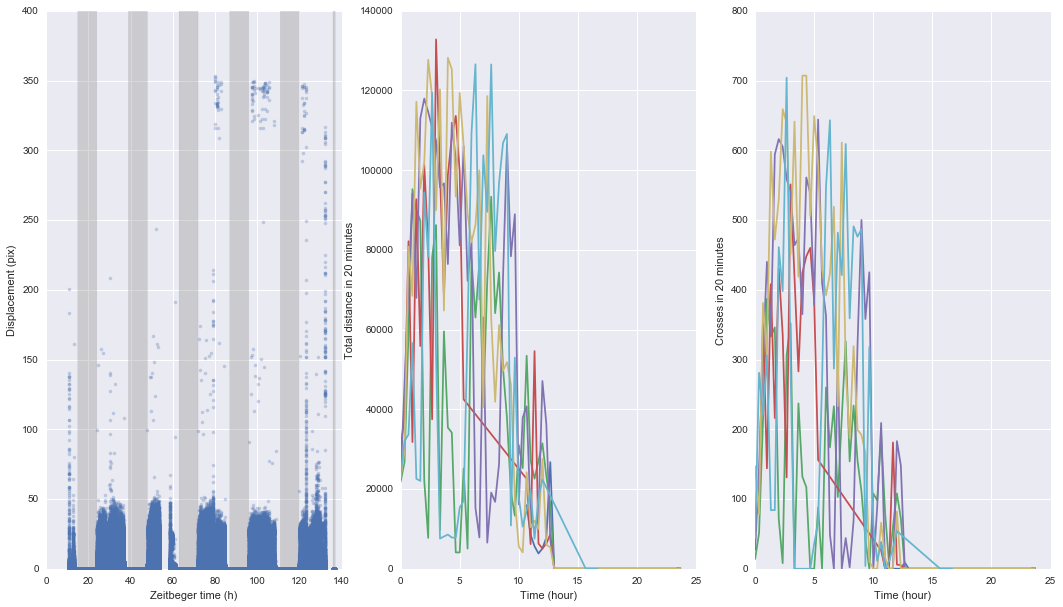

In [ ]:
process_animal('2CW317', '7/20/2016', ndays=6, save=True)

In [ ]:
process_animal('Z1Pi229', '8/3/2016', ndays=15, save=True)

Z1Pi229/0803
Z1Pi229/0804
Z1Pi229/0805


In [ ]:
process_animal('Z1Pi230', '8/3/2016', ndays=13, save=True)

In [ ]:
process_animal('LB2', '9/19/2016', ndays=6, save=True)

In [ ]:
process_animal('LB11', '8/22/2016', ndays=9, save=True)

In [ ]:
process_animal('Or128', '8/22/2016', ndays=9, save=True)